#Import

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
from google.colab import files
upload = files.upload()

Saving boston_weather_data.csv to boston_weather_data.csv


In [ ]:
project = pd.read_csv("boston_weather_data.csv",
                 index_col = 'time', parse_dates=True)

#Preprocessing

In [ ]:
project.isna().sum() #check for nan

tavg      1
tmin      0
tmax      0
prcp      0
wdir    587
wspd      0
pres    161
dtype: int64

In [ ]:
project = project.dropna()

In [ ]:
project.isna().sum()

tavg    0
tmin    0
tmax    0
prcp    0
wdir    0
wspd    0
pres    0
dtype: int64

In [ ]:
type(project)

pandas.core.frame.DataFrame

In [ ]:
project.index

DatetimeIndex(['2013-03-01', '2013-03-02', '2013-03-04', '2013-03-06',
               '2013-03-07', '2013-03-08', '2013-03-09', '2013-03-11',
               '2013-03-12', '2013-03-13',
               ...
               '2023-02-20', '2023-02-21', '2023-02-22', '2023-02-23',
               '2023-02-24', '2023-02-25', '2023-02-26', '2023-02-27',
               '2023-02-28', '2023-03-01'],
              dtype='datetime64[ns]', name='time', length=2978, freq=None)

In [ ]:
project.head(3)

,tavg,tmin,tmax,prcp,wdir,wspd,pres
time,,,,,,,
2013-03-01,3.2,1.1,5.0,0.0,342.0,15.1,1002.7
2013-03-02,3.1,1.1,5.6,0.0,307.0,14.4,1004.2
2013-03-04,1.8,-0.6,5.0,0.0,303.0,28.1,1003.0


In [ ]:
project.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2978 entries, 2013-03-01 to 2023-03-01
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tavg    2978 non-null   float64
 1   tmin    2978 non-null   float64
 2   tmax    2978 non-null   float64
 3   prcp    2978 non-null   float64
 4   wdir    2978 non-null   float64
 5   wspd    2978 non-null   float64
 6   pres    2978 non-null   float64
dtypes: float64(7)
memory usage: 186.1 KB


In [ ]:
#reconvert data type
project["tavg"]= project["tavg"].astype(int)
project["tmin"]= project["tmin"].astype(int)
project["tmax"]= project["tmax"].astype(int)
project["prcp"]= project["prcp"].astype(int)
project["wdir"]= project["wdir"].astype(int)
project["pres"]= project["pres"].astype(int)
project["wspd"]= project["wspd"].astype(int)

In [ ]:
project.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2978 entries, 2013-03-01 to 2023-03-01
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   tavg    2978 non-null   int64
 1   tmin    2978 non-null   int64
 2   tmax    2978 non-null   int64
 3   prcp    2978 non-null   int64
 4   wdir    2978 non-null   int64
 5   wspd    2978 non-null   int64
 6   pres    2978 non-null   int64
dtypes: int64(7)
memory usage: 186.1 KB


#Temp Info

<Axes: xlabel='time'>

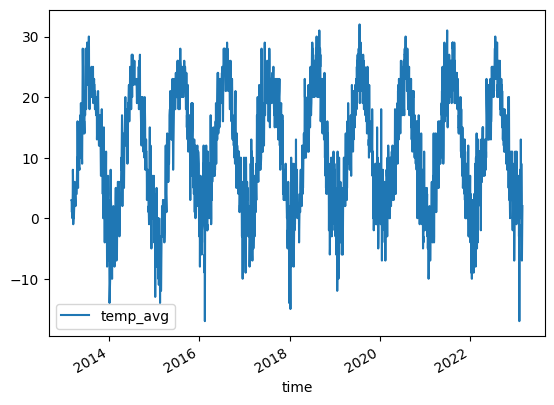

In [ ]:
#graph

%matplotlib inline
project['tavg'].plot(legend = True, label = 'temp_avg')
#project['tmax'].plot(legend = True, label = 'max')
#project['tmin'].plot(legend = True, label = 'min')
#project['wdir'].plot(legend = True, label = 'wind_dir')
#project['wspd'].plot(legend = True, label = 'wind_speed')
#project['pres'].plot(legend = True, label = 'pressure')

<Axes: xlabel='time'>

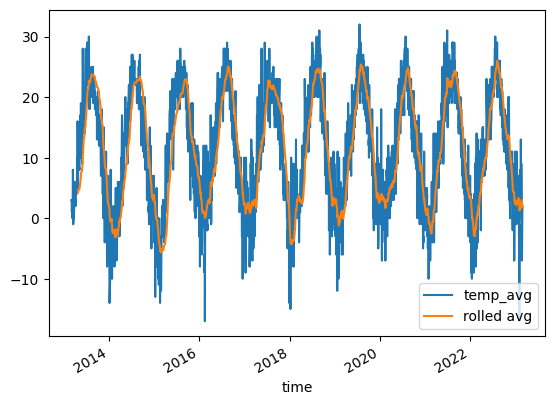

In [ ]:
#roll data to see which column to use -- any column works

rolled_data = project.rolling(window = 30).mean()['tavg']

%matplotlib inline
project['tavg'].plot(legend = True, label = 'temp_avg')
rolled_data.plot(legend = True, label = 'rolled avg')

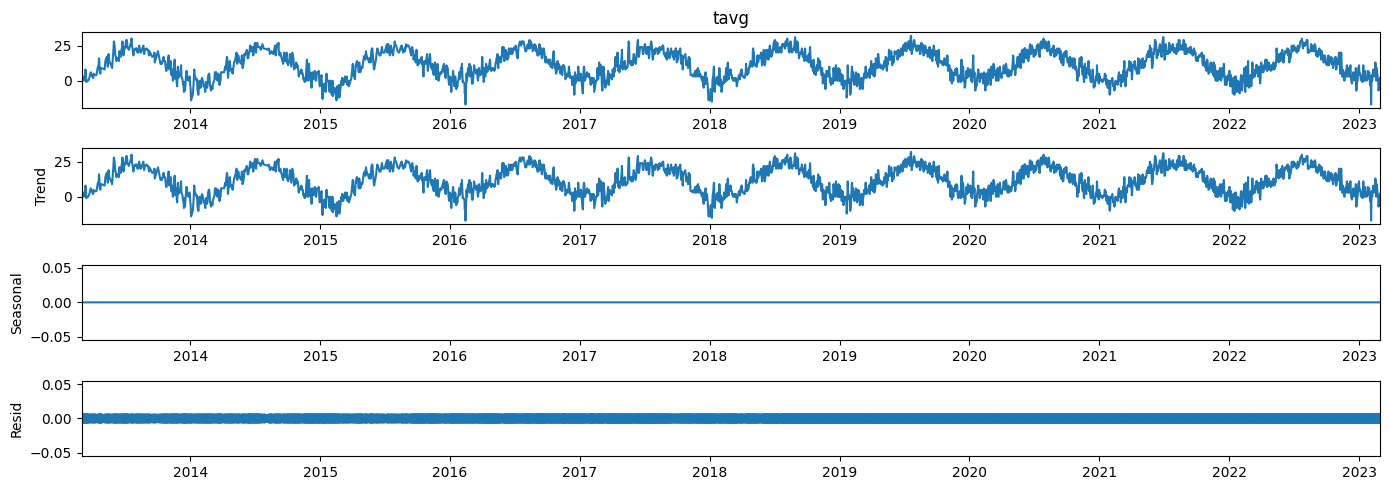

In [ ]:
from pandas.core.series import Frequency
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

decomposed = seasonal_decompose(project['tavg'], model = 'add', extrapolate_trend='freq', period=1)

rcParams['figure.figsize'] = 14,5
decomposed.plot();

#Sarima Model

In [ ]:
#basic variable creation
#logic goes like this -- todays temp is based on yesterdays temp, so tomorrows temp is based on todays temp, and the day after tomorrow is based on tomorrow, etc. 

In [ ]:
#shift temp to next day
predict_df = project['tavg'].to_frame().shift(1).rename(columns = {'tavg' : 'prediction data'})
actual_df = project['tavg'].to_frame().rename(columns = {'tavg' : 'actual data'})

#concat the predict_df and actual_df
one_day = pd.concat([actual_df, predict_df], axis = 1)
one_day.head()

,actual data,prediction data
time,,
2013-03-01,3,NaN
2013-03-02,3,3.0
2013-03-04,1,3.0
2013-03-06,3,1.0
2013-03-07,0,3.0


In [ ]:
#have to select from second row since first row has nan value (because of shifting)
one_day = one_day[1:]
one_day.head()

,actual data,prediction data
time,,
2013-03-02,3,3.0
2013-03-04,1,3.0
2013-03-06,3,1.0
2013-03-07,0,3.0
2013-03-08,0,0.0


In [ ]:
#check rsme score

from sklearn.metrics import mean_squared_error as mse
from math import sqrt

error = sqrt(mse(one_day['actual data'], one_day['prediction data']))
print (error)

3.762382981171695


In [ ]:
#use SARIMA model to create forecast

#documation - https://www.statsmodels.org/devel/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In [ ]:
import itertools
import statsmodels.api as sm

In [ ]:
#define pdq to take any value from 0-2
p = d = q = range(0,2)

#generate different combination of pdq
pdq = list(itertools.product(p,d,q))

#generate different seasonal combination of pdq
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list (itertools.product(p,d,q))]

In [ ]:
print (pdq[1], seasonal_pdq[1])

(0, 0, 1) (0, 0, 1, 12)


In [ ]:
#ignore warnings generated by code
import warnings
warnings.filterwarnings('ignore')

#create for loop to find best aic combination 
for param in pdq:
  for param_seasonal in seasonal_pdq:
    try:
      mod = sm.tsa.statespace.SARIMAX(one_day['actual data'],
                                      order = param,
                                      seasonal_order = param_seasonal,
                                      enforce_stationarity = False,
                                      enforce_invertibility = False)
      results = mod.fit()

      print (param, param_seasonal, results.aic)
    except:
      continue


#(1, 1, 1) (0, 1, 1, 12) 15816.78172542352 -- best aic combo (unless I missed a smaller one)

(0, 0, 0) (0, 0, 0, 12) 24414.19845729259
(0, 0, 0) (0, 0, 1, 12) 22053.20759139974
(0, 0, 0) (0, 1, 0, 12) 19077.982625981826
(0, 0, 0) (0, 1, 1, 12) 18800.81901228718
(0, 0, 0) (1, 0, 0, 12) 18956.8663159173
(0, 0, 0) (1, 0, 1, 12) 18808.008296740696
(0, 0, 0) (1, 1, 0, 12) 18769.407571388932
(0, 0, 0) (1, 1, 1, 12) 18757.060825538196
(0, 0, 1) (0, 0, 0, 12) 21222.494734364736
(0, 0, 1) (0, 0, 1, 12) 19559.620340050176
(0, 0, 1) (0, 1, 0, 12) 17840.258356635484
(0, 0, 1) (0, 1, 1, 12) 17350.827758519867
(0, 0, 1) (1, 0, 0, 12) 17641.72545191836
(0, 0, 1) (1, 0, 1, 12) 17340.617124913944
(0, 0, 1) (1, 1, 0, 12) 17365.830272079613
(0, 0, 1) (1, 1, 1, 12) 17327.26149550279
(0, 1, 0) (0, 0, 0, 12) 16330.463744919645
(0, 1, 0) (0, 0, 1, 12) 16270.958188651599
(0, 1, 0) (0, 1, 0, 12) 18377.287522153943
(0, 1, 0) (0, 1, 1, 12) 16262.651518625937
(0, 1, 0) (1, 0, 0, 12) 16275.465067649122
(0, 1, 0) (1, 0, 1, 12) 16272.953726980177
(0, 1, 0) (1, 1, 0, 12) 17451.156076222953
(0, 1, 0) (1, 1, 1

In [ ]:
#actual forecast model
mod2 = sm.tsa.statespace.SARIMAX(one_day['actual data'],
                                      order =(1,1,1),
                                      seasonal_order = (0,1,1,12),
                                      enforce_stationrity = False,
                                      enforce_invertibility = False)

results2 = mod2.fit()

In [ ]:
results_print = []
results_print = results2.get_prediction(start=pd.to_datetime('2020-01-01'), end=pd.to_datetime('2021-01-01'), dynamic=False)
results_print = results_print.predicted_mean.apply(np.exp)
print(results_print)

time
2020-01-01     58.614439
2020-01-02     54.000475
2020-01-03     36.756809
2020-01-04    594.926225
2020-01-05    653.001724
                 ...    
2020-12-28      2.607455
2020-12-29      6.094976
2020-12-30      5.970784
2020-12-31      0.378136
2021-01-01     32.452043
Name: predicted_mean, Length: 366, dtype: float64


#Results

In [ ]:
import matplotlib.pyplot as plt

results2.plot_diagnostics(figsize = (20,10))
plt.show()

In [ ]:
#to retreve prediction results

pred = results2.get_prediction(start = pd.to_datetime('2020-01-01'), dynamic = False)   #retreve prediction results from forecast model
#set prediction to 2014-08-01 (leave 1/3 of df to be predicted)

pred_ci = pred.conf_int()    #retreve prediction results from pred
pred_ci.head(3)

,lower actual data,upper actual data
time,,
2020-01-01,-2.795926,10.937888
2020-01-02,-2.877813,10.855799
2020-01-03,-3.262477,10.471124


Text(0, 0.5, 'Average Tempture')

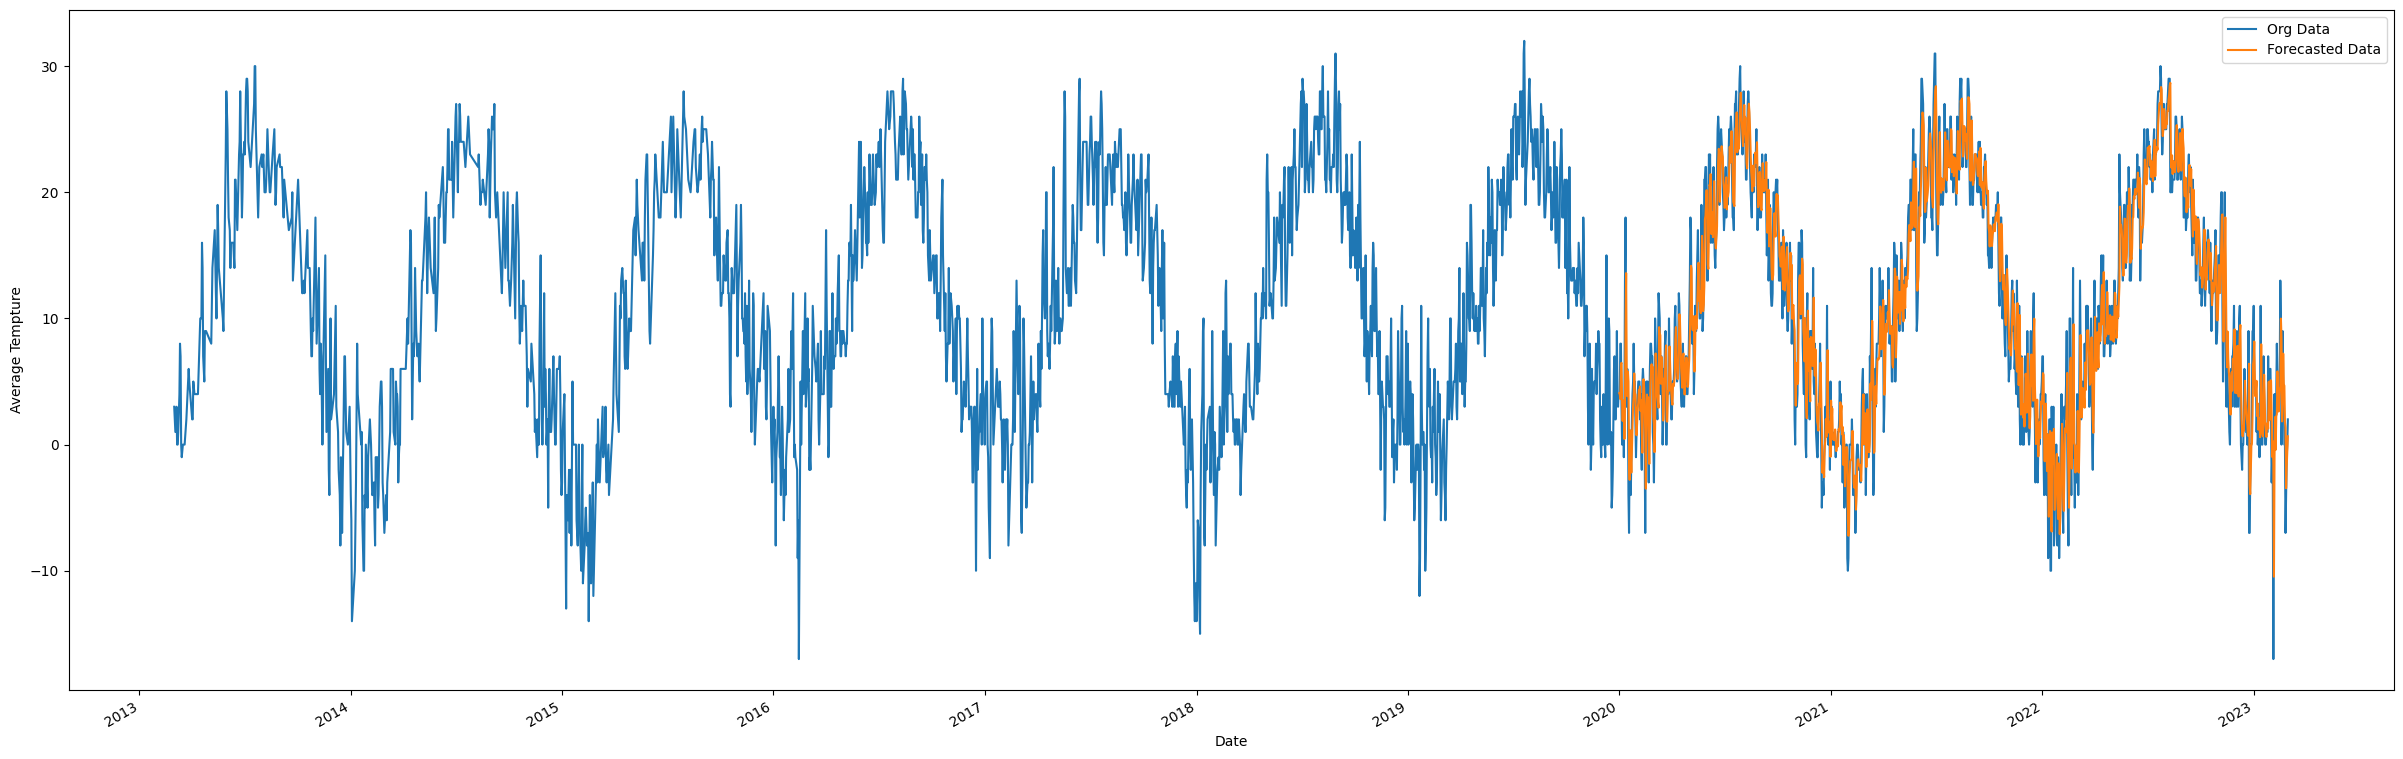

In [ ]:
%matplotlib inline
one_day['actual data'].plot(legend = True, label = 'Org Data', figsize = (30,5))
#one_day.rolling(window = 30).mean()['actual data'].plot()                                                              #rolled data

pred.predicted_mean.plot(legend = True, label = 'Forecasted Data', figsize = (30,10))      
#pred.predicted_mean.plot(legend = True, label = 'Forecasted Data', figsize = (30,10), xlim = ['2022-10-01', '2022-11-03'])     #graph specific date -- change xlim if want to change date

plt.xlabel('Date')
plt.ylabel('Average Tempture')